# *FEniCS NB:* Laser Pulse Crossing a Crystal
### *File:*    fn_simp_06a.py — propagate only the laser pulse

The Frantz-Nodvik equations
$$
\begin{align}
  \partial_t n + c\partial x &= \sigma c n \Delta, \\
  \partial_t \Delta          &= -\gamma \sigma c n \Delta, \\
\end{align}
$$
are a pair of coupled, first-order PDEs that describe
the propagation of a one-dimensional laser pulse across a
slab of laser gain material composed of two-level atoms.
Here, $x$ and $t$ denote respectively distance along the beam axis and
the time; $n(x,t)$ denotes photon number density in the medium;
and $\Delta(x,t)$ denotes the “population inversion”, $N_2 - N_1$,
giving the difference between the number density of atoms
in the excited state as compared to those in the ground state.
In addition, $c$ denotes the speed of light in the medium,
$\sigma$ the resonance absorption cross-section,
and $\gamma$ a factor related to the relative degeneracy
of the ground and excited states.

One set of boundary conditions relevant to this problem are
the initial population inversion over the domain of interest,
together with the initial profile of the incident laser pulse.

The only dynamical equation is that of the excited states in the crystal.

Experimenting with different solver here...

File:  fn_simp_01.py

This simple test shows an initial laser pulse envelope.
The envelope propagates to the right, while also dispersing.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# import os
# import sys
# from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from fenics import *
from mshr import *

Describe the simulation: parameters, domain, boundary conditions, initial conditions.

In [3]:
# set simulation parameters: domain, crystal, laser, time step
# -- simulation domain
Ld = 1.00         # length of simulation domain (we force, see below, domain to [0,1])
mesh_d = 226      # mesh density
ds = Ld / mesh_d  # size of individual mesh cells
# -- crystal
Lc = 100 * ds     # length of crystal
D0 = 10.0         # initial population inversion density
# -- laser pulse (normalized parameters)
cl = 1.00         # speed of light in vacuum
cm = 163 * ds     # speed of light in crystal
lp_w = 63 * ds    # laser pulse width
lp_hw = lp_w / 2  # laser pulse half-width
lp_x0 = 0.10      # laser pulse starting point
lp_n0 = 1.00      # incident photon density
# -- time step
T = 183 * ds      # total simulation time
n_steps = 200     # number of time steps
dt = T / n_steps  # size of time step
nip = 10          # number of intervals between plots

# create domain: a 1D mesh on the unit interval [0,1]
mesh = UnitIntervalMesh(mesh_d)
V = FunctionSpace(mesh, "CG", 1)

# define boundary functions: left and right ends
def on_L(x, on_boundary):
    return (on_boundary and near(x[0], 0.))

def on_R(x, on_boundary):
    return (on_boundary and near (x[0], 1.))
    
# specify boundary conditions
bc_L = DirichletBC(V, Constant(0), on_L)
bc_R = DirichletBC(V, Constant(0), on_R)
bc = [bc_L, bc_R]
# bc = bc_L

# specify initial conditions
# -- define profile of incident laser pulse: half wave near left edge of domain
nph_init = Expression(('x[0]>2.*ds && x[0]<(lp_w-2.*ds) ? \
                        lp_n0*sin(pi*(x[0]-2.*ds)/(lp_w-4.*ds)) : 0.'), \
                       degree=1, lp_w=0.2, Lc=Lc, lp_n0=lp_n0, ds=ds)
# -- initialize nph_j
nph   = interpolate(nph_init, V)
nph_j = interpolate(nph_init, V)

Set up the variational problem.

In [4]:
# define variational problem
nph = TrialFunction(V)
v   = TestFunction(V)
F = nph * v * dx - nph_j * v * dx + cm * dt * nph.dx(0) * v * dx
# F = ( nph * v - nph_j * v + cm * dt * nph.dx(0) * v ) * dx
# F = ( nph - nph_j + cm * dt * nph.dx(0) ) * v * dx
# solve(a == L, nph, bc)
a, L = lhs(F), rhs(F)
    
# project the initial pulse profile onto the solution vector
# nph = interpolate(nph_init, V)
# and initialize
# nph_prev.assign(nph)

Execute simulation.

(0.0, 0.2)

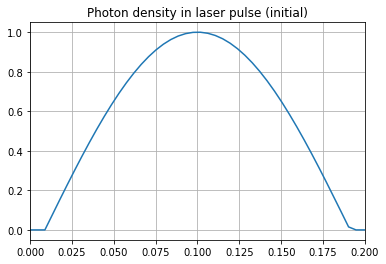

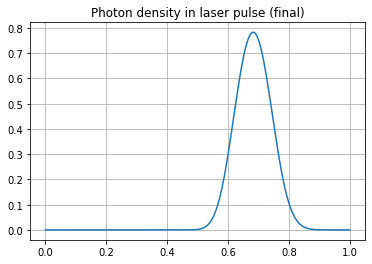

In [5]:
# inital plot of the laser pulse envelope
nplot = project(interpolate(nph_init, V), V)
plot(nplot, title=('Photon density in laser pulse (initial)'))
plt.xlim([0.00, 0.20])
plt.grid(True)
plt.show()
plt.close()

# -- initialize nph_j
# nph_j = interpolate(nph_init, V)

# F = nph * v * dx - nph_j * v * dx + cm * dt * nph.dx(0) * v * dx
# F = ( nph * v - nph_j * v + cm * dt * nph.dx(0) * v ) * dx
# F = ( nph - nph_j + cm * dt * nph.dx(0) ) * v * dx
# a, L = lhs(F), rhs(F)
# solve(a == L, nph, bc)
# solve(F == 0, nph, bc)

nph = Function(V)
# F = nph * v * dx - nph_j * v * dx + cm * dt * nph.dx(0) * v * dx
for ii in range(n_steps):
#     solve(F == 0, nph, bc)
    solve(a == L, nph, bc)
    nph_j.assign(nph)

# final plot of the laser pulse envelope
nplot = project(nph, V)
plot(nplot, title=('Photon density in laser pulse (final)'))
# plt.xlim([0.00, 0.20])
plt.grid(True)
plt.show()
plt.close()

In [ ]:
nph = Function(V)
for i_loop in range(0, n_steps):
    solve(F == 0, nph, bc)
    nph_j.assign(nph)
    
# final plot of the laser pulse envelope
nplot = project(nph, V)
plot(nplot, title=('Photon density in laser pulse (final)'))
plt.grid(True)
plt.show()
plt.close()

In [ ]:
# define time-evolution function
def evolve():

    # report initial state
    yield u_n

    # time-stepping
    u = Function(V)
    t = 0
    for n in range(1, n_steps + 1):

        # update current time
        t += dt

        # compute solution
        solve(a == L, u, bc)

        # report solution at nip-step intervals
        if n % nip == 0:
            yield u

        # update previous solution
        u_n.assign(u)
